<a href="https://colab.research.google.com/github/leodrivera/Projetos-Interessantes/blob/main/ImageColorizerColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **<font color='blue'> Artistic Colorizer </font>**

#◢ DeOldify - Colorize your own photos!

####**Credits:**

Special thanks to:

Matt Robinson and María Benavente for pioneering the DeOldify image colab notebook.  

Dana Kelley for doing things, breaking stuff & having an opinion on everything.



---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install DeOldify

In [1]:
!git clone https://github.com/jantic/DeOldify.git DeOldify 

Cloning into 'DeOldify'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2230 (delta 0), reused 0 (delta 0), pack-reused 2228
Receiving objects: 100% (2230/2230), 69.41 MiB | 37.23 MiB/s, done.
Resolving deltas: 100% (1008/1008), done.


In [9]:
cd DeOldify

/content/DeOldify


#◢ Chose DeOldify model:

* **Artistic** - This model achieves the highest quality results in image coloration, in terms of interesting details and vibrance. The most notable drawback however is that it's a bit of a pain to fiddle around with to get the best results (you have to adjust the rendering resolution or render_factor to achieve this). Additionally, the model does not do as well as stable in a few key common scenarios- nature scenes and portraits. The model uses a resnet34 backbone on a UNet with an emphasis on depth of layers on the decoder side. This model was trained with 5 critic pretrain/GAN cycle repeats via NoGAN, in addition to the initial generator/critic pretrain/GAN NoGAN training, at 192px. This adds up to a total of 32% of Imagenet data trained once (12.5 hours of direct GAN training).

* **Stable** - This model achieves the best results with landscapes and portraits. Notably, it produces less "zombies"- where faces or limbs stay gray rather than being colored in properly. It generally has less weird miscolorations than artistic, but it's also less colorful in general. This model uses a resnet101 backbone on a UNet with an emphasis on width of layers on the decoder side. This model was trained with 3 critic pretrain/GAN cycle repeats via NoGAN, in addition to the initial generator/critic pretrain/GAN NoGAN training, at 192px. This adds up to a total of 7% of Imagenet data trained once (3 hours of direct GAN training)

In [13]:
#@title DeOldify model: { run: "auto", vertical-output: true, display-mode: "code" }
colorizer_mode = "Stable" #@param ["Stable", "Artistic"]
if colorizer_mode == "Stable":
    is_artistic = False
else:
    is_artistic = True

#◢ Setup

In [14]:
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)

import torch

if not torch.cuda.is_available():
    print('GPU not available.')

In [15]:
!pip install -r colab_requirements.txt

In [16]:
import fastai
from deoldify.visualize import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?Your .*? set is empty.*?")

In [18]:
!mkdir 'models'
if is_artistic:
    !wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pt
else:
    !wget https://www.dropbox.com/s/usf7uifrctqw9rl/ColorizeStable_gen.pth?dl=0 -O ./models/ColorizeStable_gen.pth

mkdir: cannot create directory ‘models’: File exists
--2021-03-20 00:26:43--  https://www.dropbox.com/s/usf7uifrctqw9rl/ColorizeStable_gen.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/usf7uifrctqw9rl/ColorizeStable_gen.pth [following]
--2021-03-20 00:26:44--  https://www.dropbox.com/s/raw/usf7uifrctqw9rl/ColorizeStable_gen.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdba4ae82a8b8a2004f0e1a827b.dl.dropboxusercontent.com/cd/0/inline/BLBKs8TMuag__edO6LDwzXhhHDUB3pFXUrxGtrWYsl-ZlSSVbueJoJbc1rAmOtoGvrtHuCc-fLjZaK0MH7M7LzOaaLpXn8Va5d6HLkRCD_1UgdKYGG27CmiWIbHO5Ng6Fgn3EFzBPOEeYdE1SxNFC1Ec/file# [following]
--2021-03-20 00:26:44--  https://ucdba4ae82a8b8a2004f0e1a827b.dl.dropboxusercontent.com/cd/0/inline/BL

In [19]:
!wget https://media.githubusercontent.com/media/jantic/DeOldify/master/resource_images/watermark.png -O ./resource_images/watermark.png

--2021-03-20 00:27:12--  https://media.githubusercontent.com/media/jantic/DeOldify/master/resource_images/watermark.png
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9210 (9.0K) [image/png]
Saving to: ‘./resource_images/watermark.png’

./resource_images/w 100%[===================>]   8.99K  --.-KB/s    in 0s      

2021-03-20 00:27:12 (62.6 MB/s) - ‘./resource_images/watermark.png’ saved [9210/9210]



In [20]:
colorizer = get_image_colorizer(artistic=is_artistic)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#◢ Instructions

### source_url
Type in a url to a direct link of an image.  Usually that means they'll end in .png, .jpg, etc. NOTE: If you want to use your own image, upload it first to a site like Imgur. 

### render_factor
The default value of 35 has been carefully chosen and should work -ok- for most scenarios (but probably won't be the -best-). This determines resolution at which the color portion of the image is rendered. Lower resolution will render faster, and colors also tend to look more vibrant. Older and lower quality images in particular will generally benefit by lowering the render factor. Higher render factors are often better for higher quality images, but the colors may get slightly washed out. 

### watermarked
Selected by default, this places a watermark icon of a palette at the bottom left corner of the image.  This is intended to be a standard way to convey to others viewing the image that it is colorized by AI. We want to help promote this as a standard, especially as the technology continues to improve and the distinction between real and fake becomes harder to discern. This palette watermark practice was initiated and lead by the company MyHeritage in the MyHeritage In Color feature (which uses a newer version of DeOldify than what you're using here).

#### How to Download a Copy
Simply right click on the displayed image and click "Save image as..."!

## Pro Tips

You can evaluate how well the image is rendered at each render_factor by using the code at the bottom (that cell under "See how well render_factor values perform on a frame here"). 

#◢ Colorize!!

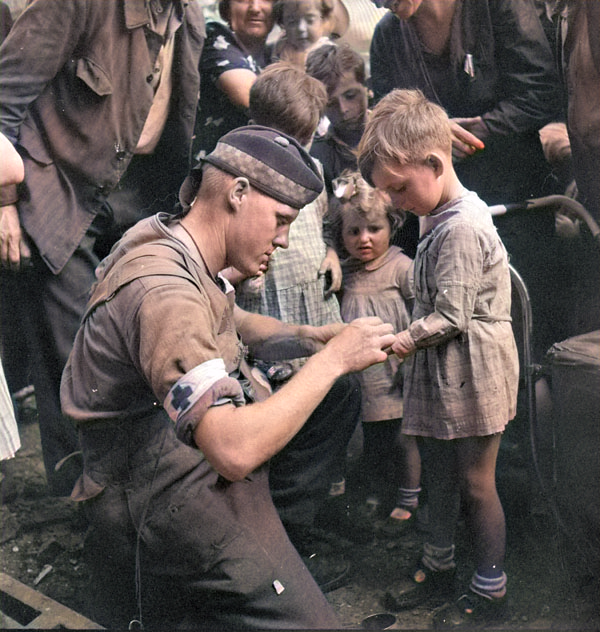

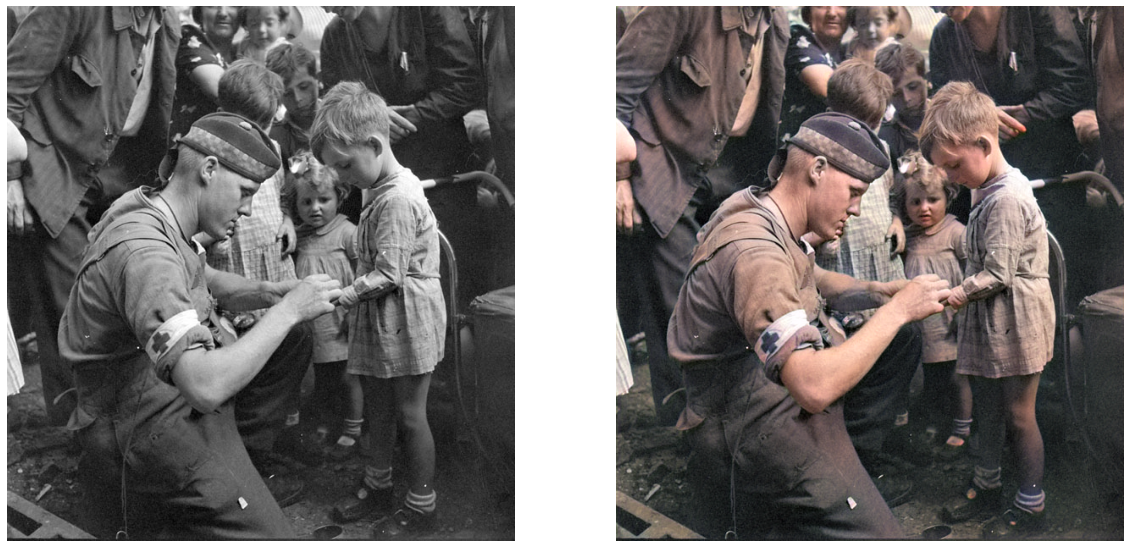

In [21]:
source_url = 'https://www.bac-lac.gc.ca/eng/discover/military-heritage/second-world-war/faces-second-war/PublishingImages/a135956-v6.jpg' #@param {type:"string"}
render_factor = 35  #@param {type: "slider", min: 7, max: 40}
watermarked = False #@param {type:"boolean"}

if source_url is not None and source_url !='':
    image_path = colorizer.plot_transformed_image_from_url(url=source_url, render_factor=render_factor, compare=True, watermarked=watermarked)
    show_image_in_notebook(image_path)
else:
    print('Provide an image url and try again.')

## See how well render_factor values perform on the image here

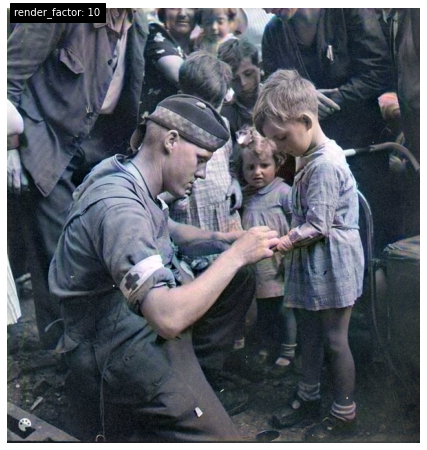

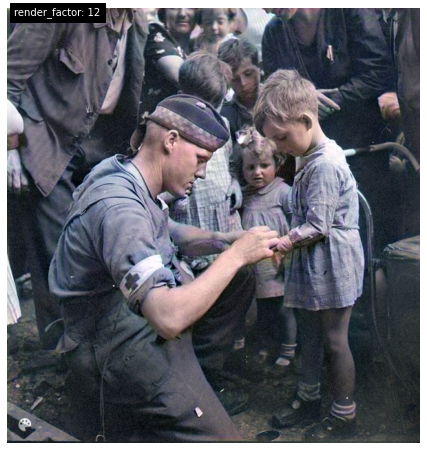

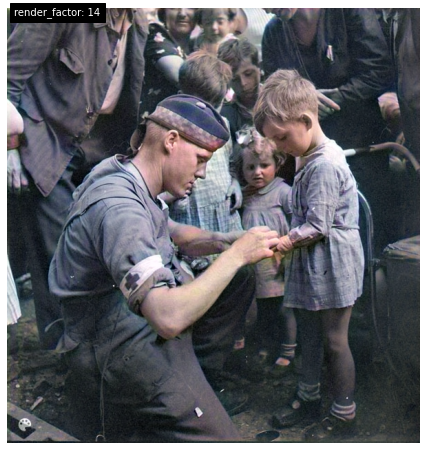

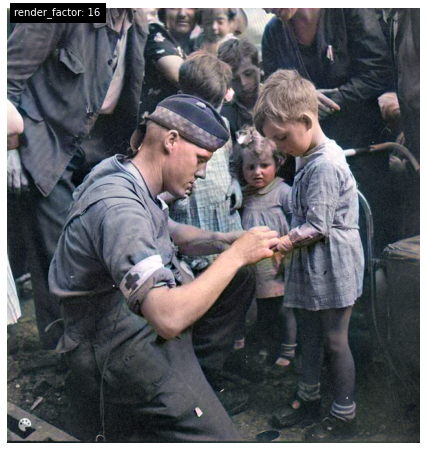

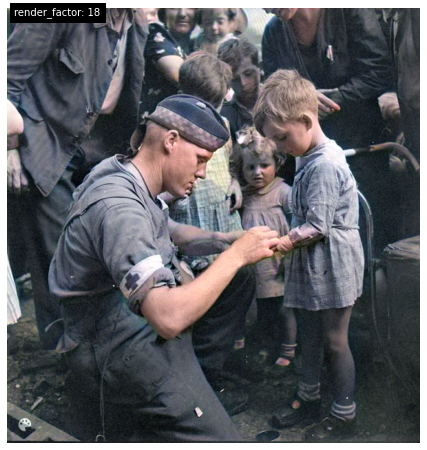

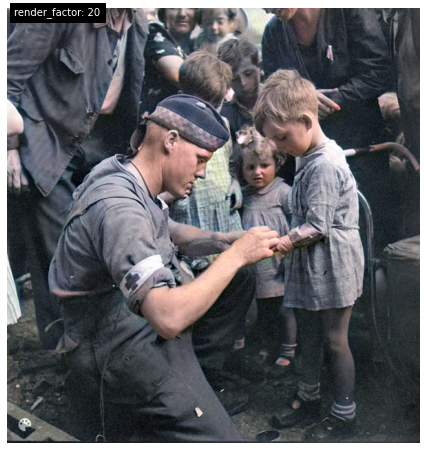

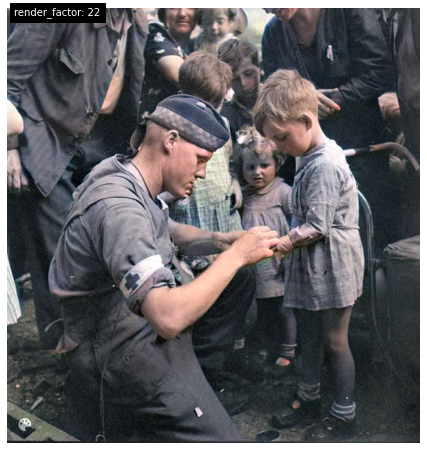

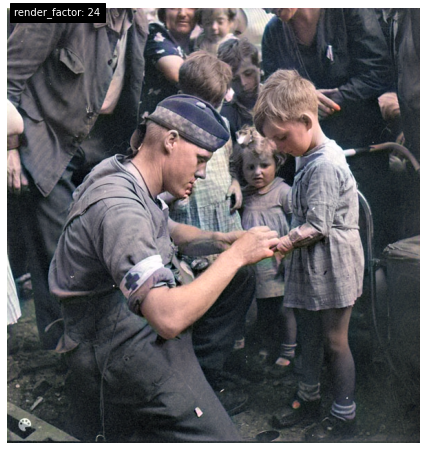

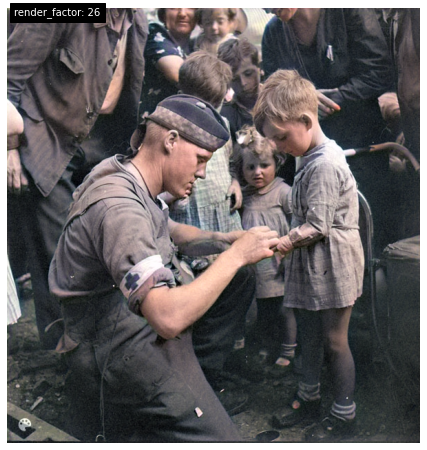

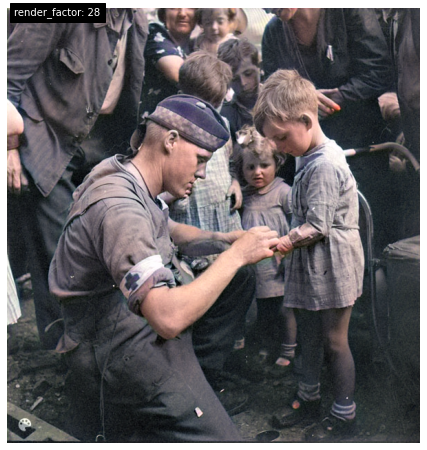

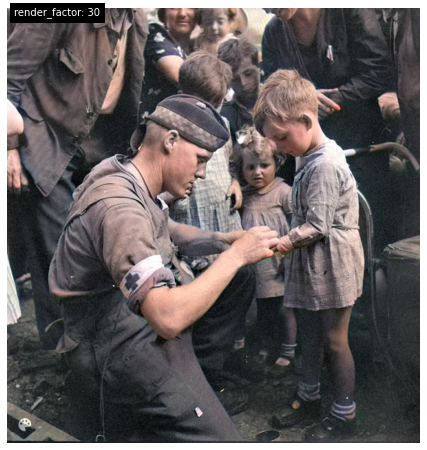

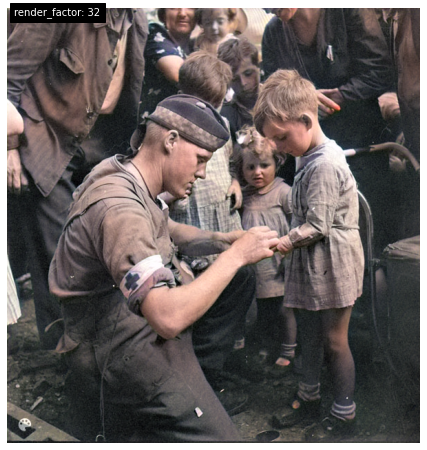

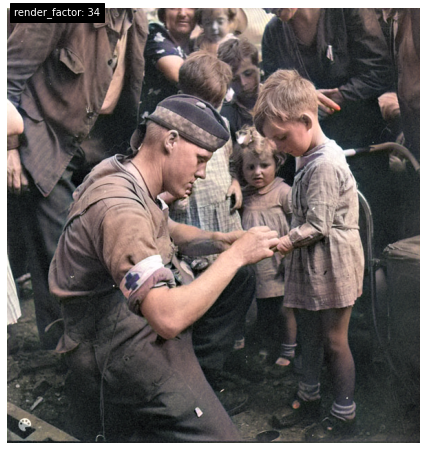

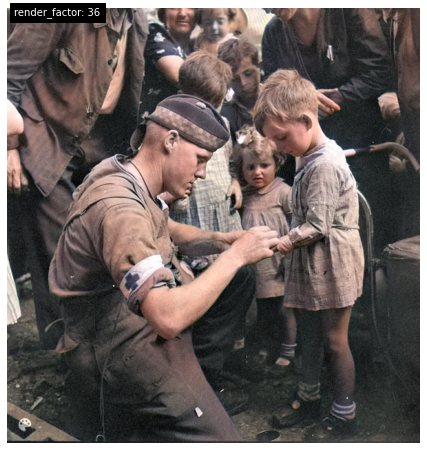

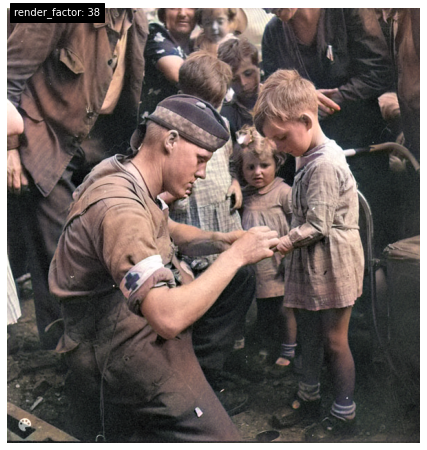

In [13]:
for i in range(10,40,2):
    colorizer.plot_transformed_image('test_images/image.png', render_factor=i, display_render_factor=True, figsize=(8,8))

---
#⚙ Recommended image sources 
* [/r/TheWayWeWere](https://www.reddit.com/r/TheWayWeWere/)